In [1]:
import re, nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

D:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def normalizer(Reviews): 
    soup = BeautifulSoup(Reviews, 'lxml')   # removing HTML encoding such as ‘&amp’,’&quot’
    souped = soup.get_text()
    only_words = re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\\\S+)"," ", souped) # removing @mentions, hashtags, urls.

    tokens = nltk.word_tokenize(only_words)
    removed_letters = [word for word in tokens if len(word)>2] # removing words with length less than or equal to 2
    lower_case = [l.lower() for l in removed_letters]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [3]:
def Cross_validation(data, targets, tfidf, clf_cv, model_name): 

    kf = KFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
    scores=[]
    data_train_list = []
    targets_train_list = []
    data_test_list = []
    targets_test_list = []
    iteration = 0
    print("Performing cross-validation for {}...".format(model_name))
    for train_index, test_index in kf.split(data):
        iteration += 1
        print("Iteration ", iteration)
        data_train_cv, targets_train_cv = data[train_index], targets[train_index]
        data_test_cv, targets_test_cv = data[test_index], targets[test_index]
        data_train_list.append(data_train_cv) # appending training data for each iteration
        data_test_list.append(data_test_cv) # appending test data for each iteration
        targets_train_list.append(targets_train_cv) # appending training targets for each iteration
        targets_test_list.append(targets_test_cv) # appending test targets for each iteration
        tfidf.fit(data_train_cv) # learning vocabulary of training set
        data_train_tfidf_cv = tfidf.transform(data_train_cv)
        print("Shape of training data: ", data_train_tfidf_cv.shape)
        data_test_tfidf_cv = tfidf.transform(data_test_cv)
        print("Shape of test data: ", data_test_tfidf_cv.shape)
        clf_cv.fit(data_train_tfidf_cv, targets_train_cv) # Fitting SVC
        score = clf_cv.score(data_test_tfidf_cv, targets_test_cv) # Calculating accuracy
        scores.append(score) # appending cross-validation accuracy for each iteration
    print("List of cross-validation accuracies for {}: ".format(model_name), scores)
    mean_accuracy = np.mean(scores)
    print("Mean cross-validation accuracy for {}: ".format(model_name), mean_accuracy)
    print("Best cross-validation accuracy for {}: ".format(model_name), max(scores))
    max_acc_index = scores.index(max(scores)) # best cross-validation accuracy
    max_acc_data_train = data_train_list[max_acc_index] # training data corresponding to best cross-validation accuracy
    max_acc_data_test = data_test_list[max_acc_index] # test data corresponding to best cross-validation accuracy
    max_acc_targets_train = targets_train_list[max_acc_index] # training targets corresponding to best cross-validation accuracy
    max_acc_targets_test = targets_test_list[max_acc_index] # test targets corresponding to best cross-validation accuracy

    return mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test

In [5]:
def c_matrix(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, clf, model_name):
    tfidf.fit(max_acc_data_train)
    max_acc_data_train_tfidf = tfidf.transform(max_acc_data_train)
    max_acc_data_test_tfidf = tfidf.transform(max_acc_data_test)
    clf.fit(max_acc_data_train_tfidf, max_acc_targets_train) # Fitting Model
    targets_pred = clf.predict(max_acc_data_test_tfidf) # Prediction on test data
    conf_mat = confusion_matrix(max_acc_targets_test, targets_pred)
    d={0:'Negative', 1: 'Positive'}
    sentiment_df = targets.drop_duplicates().sort_values()
    sentiment_df= sentiment_df.apply(lambda x:d[x])
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=sentiment_df.values, yticklabels=sentiment_df.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix (Best Accuracy) - {}".format(model_name))
    plt.show()

In [6]:
def SVC_Save(data, targets, tfidf):
    tfidf.fit(data) # learn vocabulary of entire data
    data_tfidf = tfidf.transform(data)
    pd.DataFrame.from_dict(data=dict([word, i] for i, word in enumerate(tfidf.get_feature_names())), orient='index').to_csv('vocabulary_SVC.csv', header=False)
    print("Shape of tfidf matrix for saved SVC Model: ", data_tfidf.shape)
    clf = LinearSVC().fit(data_tfidf, targets)
    joblib.dump(clf, 'svc.sav')

In [7]:
def NBC_Save(data, targets, tfidf):
    tfidf.fit(data) # learn vocabulary of entire data
    data_tfidf = tfidf.transform(data)
    pd.DataFrame.from_dict(data=dict([word, i] for i, word in enumerate(tfidf.get_feature_names())), orient='index').to_csv('vocabulary_NBC.csv', header=False)
    print("Shape of tfidf matrix for saved NBC Model: ", data_tfidf.shape)
    clf = MultinomialNB(alpha=1.0).fit(data_tfidf, targets)
    joblib.dump(clf, 'nbc.sav')

In [8]:
def main():
    #### Reading training dataset as dataframe
    df = pd.read_csv("train.csv", encoding = "ISO-8859-1")
    pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
    #### Normalizing Reviews
    df['normalized_tweet'] = df.tweet.apply(normalizer)
    df = df[df['normalized_tweet'].map(len) > 0] # removing rows with normalized reviews of length 0
    print("Printing top 5 rows of dataframe showing original and cleaned reviews....")
    print(df[['tweet','normalized_tweet']].head())
    d = {'Low': 0, 'High': 1}
    df['label'] = df['label'].astype(str).map(d).fillna(df['label'])
    #df.Rating.replace(to_replace=['Low', 'High'], value=[0, 1])
    #df.drop(['Medicine', 'Condition'], axis=1, inplace=True)
    #### Saving cleaned reviews to csv
    df.to_csv('cleaned_tweet_data.csv', encoding='utf-8', index=False)
    #### Reading cleaned reviews as dataframe
    cleaned_data = pd.read_csv("cleaned_tweet_data.csv", encoding = "ISO-8859-1")
    pd.set_option('display.max_colwidth', -1)
    data = cleaned_data.normalized_tweet
    targets = cleaned_data.label
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=30, norm='l2', ngram_range=(1,3)) # min_df=30 is a clever way of feature engineering

    SVC_clf = LinearSVC() # SVC Model
    SVC_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test = Cross_validation(data, targets, tfidf, SVC_clf, "SVC") # SVC cross-validation
    c_matrix(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, SVC_clf, "SVC") # SVC confusion matrix

    NBC_clf = MultinomialNB() # NBC Model
    NBC_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test = Cross_validation(data, targets, tfidf, NBC_clf, "NBC") # NBC cross-validation
    c_matrix(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, NBC_clf, "NBC") # NBC confusion matrix

    if SVC_mean_accuracy > NBC_mean_accuracy:
        SVC_Save(data, targets, tfidf)
    else:
        NBC_Save(data, targets, tfidf)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bhara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


Printing top 5 rows of dataframe showing original and cleaned reviews....
                                                                                                                                   tweet  \
0  #fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone        
1  Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperiasâ¦ http://instagram.com/p/YGEt5JC6JM/   
2  We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu             
3  I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/                        
4  What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!            

                                                                                     

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Performing cross-validation for SVC...
Iteration  1
Shape of training data:  (7127, 603)
Shape of test data:  (792, 603)
Iteration  2
Shape of training data:  (7127, 596)
Shape of test data:  (792, 596)
Iteration  3
Shape of training data:  (7127, 603)
Shape of test data:  (792, 603)
Iteration  4
Shape of training data:  (7127, 598)
Shape of test data:  (792, 598)
Iteration  5
Shape of training data:  (7127, 605)
Shape of test data:  (792, 605)
Iteration  6
Shape of training data:  (7127, 611)
Shape of test data:  (792, 611)
Iteration  7
Shape of training data:  (7127, 602)
Shape of test data:  (792, 602)
Iteration  8
Shape of training data:  (7127, 608)
Shape of test data:  (792, 608)
Iteration  9
Shape of training data:  (7127, 602)
Shape of test data:  (792, 602)
Iteration  10
Shape of training data:  (7128, 634)
Shape of test data:  (791, 634)
List of cross-validation accuracies for SVC:  [0.8838383838383839, 0.88510101010101, 0.86489898989899, 0.9053030303030303, 0.887626262626262

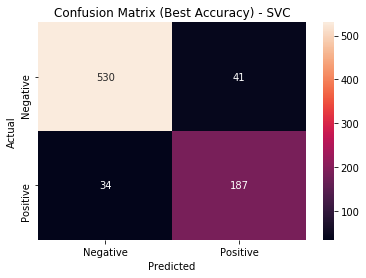

Performing cross-validation for NBC...
Iteration  1
Shape of training data:  (7127, 603)
Shape of test data:  (792, 603)
Iteration  2
Shape of training data:  (7127, 596)
Shape of test data:  (792, 596)
Iteration  3
Shape of training data:  (7127, 603)
Shape of test data:  (792, 603)
Iteration  4
Shape of training data:  (7127, 598)
Shape of test data:  (792, 598)
Iteration  5
Shape of training data:  (7127, 605)
Shape of test data:  (792, 605)
Iteration  6
Shape of training data:  (7127, 611)
Shape of test data:  (792, 611)
Iteration  7
Shape of training data:  (7127, 602)
Shape of test data:  (792, 602)
Iteration  8
Shape of training data:  (7127, 608)
Shape of test data:  (792, 608)
Iteration  9
Shape of training data:  (7127, 602)
Shape of test data:  (792, 602)
Iteration  10
Shape of training data:  (7128, 634)
Shape of test data:  (791, 634)
List of cross-validation accuracies for NBC:  [0.8813131313131313, 0.8863636363636364, 0.8636363636363636, 0.8888888888888888, 0.88636363636

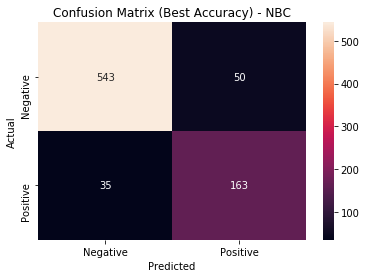

Shape of tfidf matrix for saved SVC Model:  (7919, 681)


In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
if __name__ == "__main__":
    main()